### Author: Olufemi Victor Tolulope.
###### Zindi Username: Professor

This Notebook Leverages NVIDIA NEMO to build an ASR finetuning a Conformer-CTC Large model from the Hugging face hub.

* Data used: Audio Files - WAV format
* GPU: Nvidia Tesla P100
* Total Notebook Runtime - 7 hours 50 minutes 
* Environment Used: Kaggle Kennel

In [1]:
import os
import librosa
import soundfile as sf
import json
import numpy as np

In [2]:
%%capture
!pip install frozendict
!pip install g2p_en
!pip install torch_stft
!pip install soundfile
!pip install kaldiio
!pip install pydub
!pip install pangu
!pip install tf-estimator-nightly==2.8.0.dev2021122109
!pip install folium==0.2.1

In [3]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
5. Restart the runtime (Runtime -> Restart Runtime) for any upgraded packages to take effect


NOTE: User is responsible for checking the content of datasets and the applicable licenses and determining if suitable for the intended use.
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg -y
!pip install text-unidecode
!pip install matplotlib>=3.3.2

## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[asr]

"""
Remember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!
Alternatively, you can uncomment the exit() below to crash and restart the kernel, in the case
that you want to use the "Run All Cells" (or similar) option.
"""
#exit()

  Preparing metadata (setup.py) ... - \ done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=6836d6b95e1696dc627c591ab1883239231a947f4595a17e604897b1d4670f1f
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget



libsndfile1 is already the newest version (1.0.31-2build1).
libsndfile1 set to manually installed.
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3 libwavpack1
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3 libwavpack1 sox
0 upgraded, 9 newly installed, 0 to remove and 13 not upgraded.
Need to get 961 kB of archives.
After this operation, 9292 kB of ad

'\nRemember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!\nAlternatively, you can uncomment the exit() below to crash and restart the kernel, in the case\nthat you want to use the "Run All Cells" (or similar) option.\n'

In [4]:
#import nemo
# NeMo's ASR collection - this collections contains complete ASR models and
# building blocks (modules) for ASR
import nemo.collections.asr as nemo_asr
from omegaconf import OmegaConf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [5]:
import pandas as pd
import os

In [6]:
train = pd.read_csv("/kaggle/input/swahili-audio-dataset/train.csv")
test = pd.read_csv("/kaggle/input/swahili-audio-dataset/test.csv")
train["path"] = "/kaggle/input/swahili-audio-dataset/all_wav/content/all_wav_files/" + train["audio_ID"]+".wav"
test["path"] = "/kaggle/input/swahili-audio-dataset/all_wav/content/all_wav_files/" + test["audio_ID"]+ ".wav"
test["sentence"] = " "
train

,audio_ID,path,sentence
0,audio_faa7312a,/kaggle/input/swahili-audio-dataset/all_wav/co...,huko kwa Wakiroba Mkoa wa Mara
1,audio_643a10c1,/kaggle/input/swahili-audio-dataset/all_wav/co...,Alingaa katika medani za kisiasa na uongozi nd...
2,audio_5b626e74,/kaggle/input/swahili-audio-dataset/all_wav/co...,Vitu saba ambavyo kila baba atakuwa.
3,audio_5972c5f3,/kaggle/input/swahili-audio-dataset/all_wav/co...,inaonyesha mawaziri wapya ambao wamechukua naf...
4,audio_deebd5b0,/kaggle/input/swahili-audio-dataset/all_wav/co...,ee hii pia inatumiwa na kiwanda cha
...,...,...,...
19088,audio_020c9902,/kaggle/input/swahili-audio-dataset/all_wav/co...,bado timu zitapata nafasi katika
19089,audio_7de63630,/kaggle/input/swahili-audio-dataset/all_wav/co...,Wabunge wapo huru kufanya mikutano ya hadhara ...
19090,audio_a52c777e,/kaggle/input/swahili-audio-dataset/all_wav/co...,aah mimi sio mkaaji sana mzee hata mazungumzo ...
19091,audio_9adccc74,/kaggle/input/swahili-audio-dataset/all_wav/co...,rini na saba hadi kumalizika kwake mwaka wa el...


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the CSV file into a pandas DataFrame
df = train.copy()

# Split the DataFrame into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Save the train and validation DataFrames to CSV files
train_df.to_csv('train_split.csv', index=False)
val_df.to_csv('valid_split.csv', index=False)
test.to_csv("test.csv", index=False)

print("Splitting complete. Train and validation CSV files created.")


Splitting complete. Train and validation CSV files created.


In [8]:
pip install jiwer

Note: you may need to restart the kernel to use updated packages.


In [9]:
# Example file to check data

import librosa
import IPython.display as ipd

# Load and listen to the audio file
example_file = '/kaggle/input/swahili-audio-dataset/all_wav/content/all_wav_files/audio_faa7312a.wav'
audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

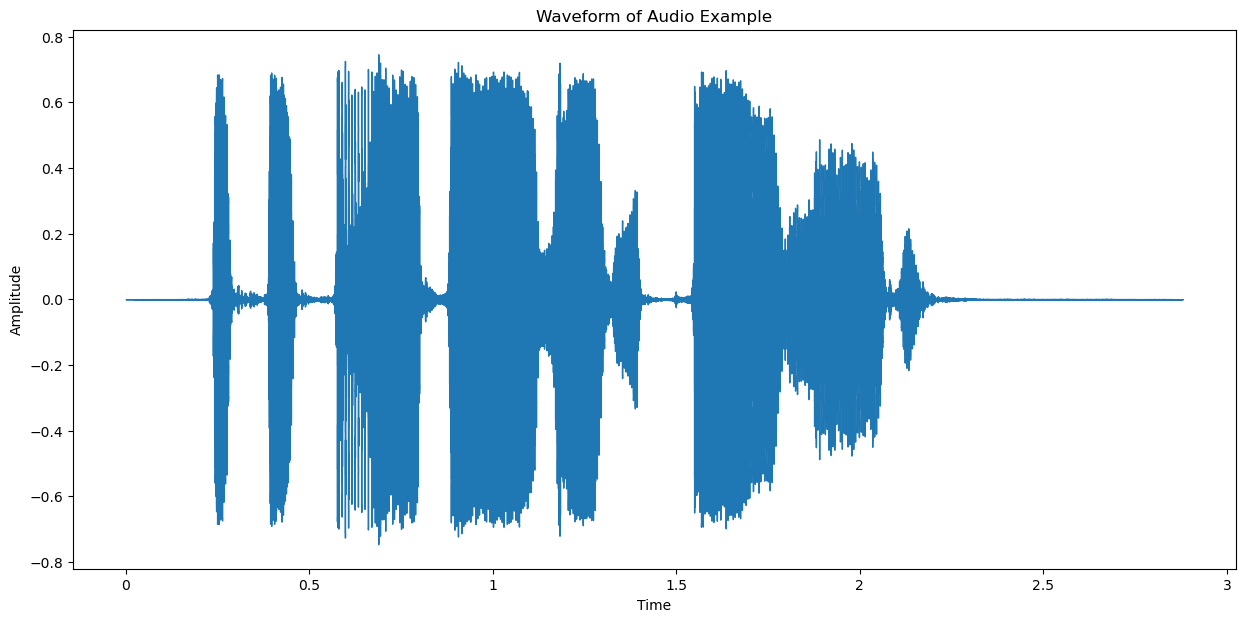

In [10]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveshow(audio)

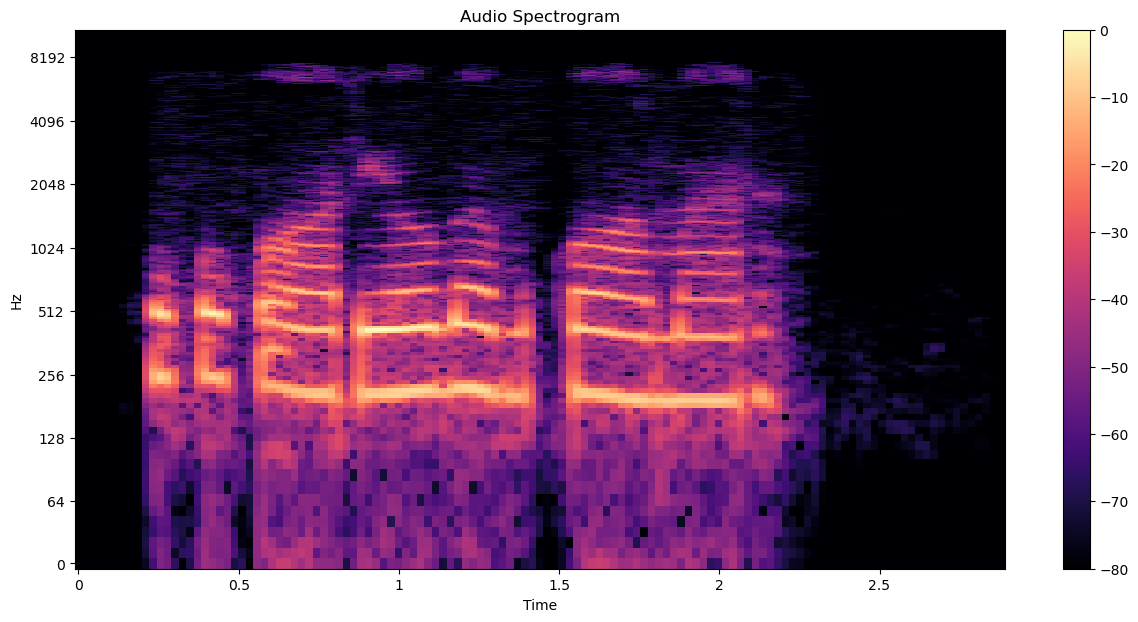

In [11]:

import numpy as np

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

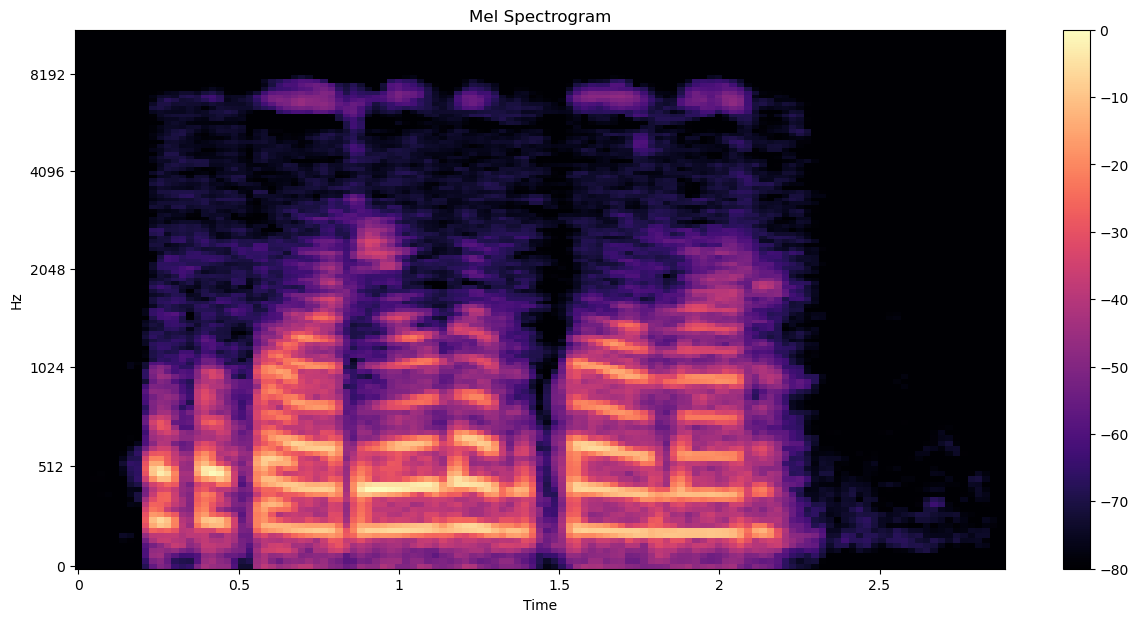

In [12]:
# Generate Mel Spectogram for the sample audio

n_fft = 2048
hop_length = 512
n_mels = 128
mel_spec = librosa.feature.melspectrogram(
    y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Display Mel spectrogram
librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram')
plt.show()


In [13]:
import nemo.collections.asr as nemo_asr
asr_model = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="yonas/stt_rw_sw_lg_conformer_ctc_large")

[NeMo I 2023-08-20 19:36:03 mixins:170] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2023-08-20 19:36:03 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/chanie/multiling/train_tarred_1bk/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 24
    shuffle: true
    num_workers: 4
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 16.7
    min_duration: 0.1
    is_tarred: true
    tarred_audio_filepaths: /data/chanie/multiling/train_tarred_1bk/audio__OP_0..1023_CL_.tar
    shuffle_n: 2048
    bucketing_strategy: synced_randomized
    bucketing_batch_size: null
    
[NeMo W 2023-08-20 19:36:03 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation c

[NeMo I 2023-08-20 19:36:03 features:289] PADDING: 0


[NeMo W 2023-08-20 19:36:05 asr_confidence_utils:195] `method_cfg` is deprecated and will be removed in the future. Please use `measure_cfg` instead.
[NeMo W 2023-08-20 19:36:05 asr_confidence_utils:200] Re-writing `measure_cfg` with the value of `method_cfg`.
[NeMo W 2023-08-20 19:36:05 asr_confidence_utils:95] `temperature` is deprecated and will be removed in the future. Please use `alpha` instead.
[NeMo W 2023-08-20 19:36:05 asr_confidence_utils:100] Re-writing `alpha` with the value of `temperature`.
[NeMo W 2023-08-20 19:36:05 asr_confidence_utils:195] `method_cfg` is deprecated and will be removed in the future. Please use `measure_cfg` instead.
[NeMo W 2023-08-20 19:36:05 asr_confidence_utils:200] Re-writing `measure_cfg` with the value of `method_cfg`.
[NeMo W 2023-08-20 19:36:05 asr_confidence_utils:95] `temperature` is deprecated and will be removed in the future. Please use `alpha` instead.
[NeMo W 2023-08-20 19:36:05 asr_confidence_utils:100] Re-writing `alpha` with the va

[NeMo I 2023-08-20 19:36:12 save_restore_connector:249] Model EncDecCTCModelBPE was successfully restored from /root/.cache/huggingface/hub/models--yonas--stt_rw_sw_lg_conformer_ctc_large/snapshots/0a005e56037a11c48e7ca8d2656aede444988b5d/stt_rw_sw_lg_conformer_ctc_large.nemo.


In [14]:
#nemo_asr.models.EncDecCTCModel.list_available_models()

In [15]:
x = []
for i in range(5):
    print("Truth: ", train.iloc[i]["sentence"])
    x.append("/kaggle/input/swahili-audio-dataset/all_wav/content/all_wav_files/"+train.iloc[i]["audio_ID"] + ".wav")

predictions_ = asr_model.transcribe(paths2audio_files=x)

for i in range(5):
    print("Prediction: ", predictions_[i])

Truth:  huko kwa Wakiroba Mkoa wa Mara
Truth:  Alingaa katika medani za kisiasa na uongozi ndani ya Serikali ya Mapinduzi ya Zanzibar
Truth:  Vitu saba ambavyo kila baba atakuwa.
Truth:  inaonyesha mawaziri wapya ambao wamechukua nafasi hiyo ni sita
Truth:  ee hii pia inatumiwa na kiwanda cha


Transcribing:   0%|          | 0/2 [00:00<?, ?it/s]

Prediction:  ko kwa wariooba mkoa wa mara
Prediction:  alingaa katika medani za kisiasa na uongozi ndani ya serikali ya mapinduzi ya zanzibar
Prediction:  vitu saba ambavyo kila baba atakua
Prediction:  na monisha mawaziri mwapya ambao amechukua nafasi hiyo misita
Prediction:  e hii pia inatumiwa na kiwanda cha


In [16]:
import os
import json
import pandas as pd
import librosa

# Function to build a manifest
def build_manifest(dataframe, manifest_path, wav_path):
    df = dataframe.copy()
    with open(manifest_path, 'w') as fout:
        for _, row in df.iterrows():
            transcript = row['sentence'].lower().strip()
            file_id = row['path']
            file_id = os.path.splitext(file_id)[0]
            file_id = file_id + '.wav'
            audio_path = os.path.join(wav_path, file_id)
            duration = librosa.get_duration(path=audio_path)

            # Write the metadata to the manifest
            metadata = {
                "audio_filepath": audio_path,
                "duration": duration,
                "text": transcript
            }
            json.dump(metadata, fout)
            fout.write('\n')

In [17]:
test

,audio_ID,path,sentence
0,audio_3c2f423a,/kaggle/input/swahili-audio-dataset/all_wav/co...,
1,audio_ca8009ec,/kaggle/input/swahili-audio-dataset/all_wav/co...,
2,audio_fffcdb86,/kaggle/input/swahili-audio-dataset/all_wav/co...,
3,audio_0e3e8e6f,/kaggle/input/swahili-audio-dataset/all_wav/co...,
4,audio_859b792d,/kaggle/input/swahili-audio-dataset/all_wav/co...,
...,...,...,...
3162,audio_bdc72517,/kaggle/input/swahili-audio-dataset/all_wav/co...,
3163,audio_50ee5991,/kaggle/input/swahili-audio-dataset/all_wav/co...,
3164,audio_b9867662,/kaggle/input/swahili-audio-dataset/all_wav/co...,
3165,audio_a0739877,/kaggle/input/swahili-audio-dataset/all_wav/co...,


In [18]:
# Building Manifests

train_manifest = 'train_manifest.json'
if not os.path.isfile(train_manifest):
    build_manifest(train_df, train_manifest, 'all_wav_files')
    print("Training manifest created.")


valid_manifest = 'valid_manifest.json'
if not os.path.isfile(valid_manifest):
    build_manifest(val_df, valid_manifest, 'all_wav_files')
    print("Validation manifest created.")

Training manifest created.
Validation manifest created.


In [19]:
# --- Config Information ---#

try:
    from ruamel.yaml import YAML
except ModuleNotFoundError:
    from ruamel_yaml import YAML
config_path = './configs/config.yaml'

if not os.path.exists(config_path):
    # Grab the config we'll use in this example
    BRANCH = 'main'
    !mkdir configs
    !wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/config.yaml

yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)
print(params)

--2023-08-20 19:37:32--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/asr/conf/config.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4280 (4.2K) [text/plain]
Saving to: ‘configs/config.yaml’

config.yaml         100%[===================>]   4.18K  --.-KB/s    in 0s      

2023-08-20 19:37:32 (33.5 MB/s) - ‘configs/config.yaml’ saved [4280/4280]

{'name': 'QuartzNet15x5', 'sample_rate': 16000, 'repeat': 1, 'dropout': 0.0, 'separable': True, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'model': {'train_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm

In [20]:
import pytorch_lightning as pl
trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=50)

In [21]:
from omegaconf import DictConfig
import copy
params['model']['train_ds']['manifest_filepath'] = train_manifest
params['model']['validation_ds']['manifest_filepath'] = valid_manifest

In [22]:
# # Bigger batch-size = bigger throughput
params['model']['train_ds']['batch_size'] = 16
params['model']['validation_ds']['batch_size'] = 16

print(params['model']['optim'])  ###

# import copy
new_opt = copy.deepcopy(params['model']['optim'])
new_opt['lr'] = 0.001

print('new_opt', new_opt)

{'name': 'novograd', 'lr': 0.01, 'betas': [0.8, 0.5], 'weight_decay': 0.001, 'sched': {'name': 'CosineAnnealing', 'monitor': 'val_loss', 'reduce_on_plateau': False, 'warmup_steps': None, 'warmup_ratio': None, 'min_lr': 0.0, 'last_epoch': -1}}
new_opt {'name': 'novograd', 'lr': 0.001, 'betas': [0.8, 0.5], 'weight_decay': 0.001, 'sched': {'name': 'CosineAnnealing', 'monitor': 'val_loss', 'reduce_on_plateau': False, 'warmup_steps': None, 'warmup_ratio': None, 'min_lr': 0.0, 'last_epoch': -1}}


In [25]:
# Use the smaller learning rate we set before  ####
asr_model.setup_optimization(optim_config=DictConfig(new_opt))

# Point to the data we'll use for fine-tuning as the training set
asr_model.setup_training_data(train_data_config=params['model']['train_ds'])

# Point to the new validation data for fine-tuning
asr_model.setup_validation_data(val_data_config=params['model']['validation_ds'])

[NeMo W 2023-08-20 19:37:34 modelPT:624] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2023-08-20 19:37:34 modelPT:735] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )


[NeMo W 2023-08-20 19:37:34 lr_scheduler:890] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


[NeMo I 2023-08-20 19:37:35 collections:196] Dataset loaded with 17179 files totalling 25.74 hours
[NeMo I 2023-08-20 19:37:35 collections:197] 4 files were filtered totalling 0.02 hours


[NeMo W 2023-08-20 19:37:35 nemo_logging:349] /opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      warnings.warn(_create_warning_msg(
    


[NeMo I 2023-08-20 19:37:35 collections:196] Dataset loaded with 1910 files totalling 2.86 hours
[NeMo I 2023-08-20 19:37:35 collections:197] 0 files were filtered totalling 0.00 hours


In [27]:
%%time
n_epochs = 25
trainer = pl.Trainer(max_epochs=n_epochs)
trainer.fit(asr_model)

[NeMo I 2023-08-20 19:37:36 modelPT:735] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )
[NeMo I 2023-08-20 19:37:36 lr_scheduler:910] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7c56680a0970>" 
    will be used during training (effective maximum steps = 26850) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 26850
    )


Sanity Checking: 0it [00:00, ?it/s]

[NeMo W 2023-08-20 19:37:36 nemo_logging:349] /opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      warnings.warn(_create_warning_msg(
    


[NeMo I 2023-08-20 19:37:39 wer_bpe:301] 
    
[NeMo I 2023-08-20 19:37:39 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-20 19:37:39 wer_bpe:303] predicted:rok gutson alioa mke wake na kutalakiana hapohapa
[NeMo I 2023-08-20 19:37:39 wer_bpe:301] 
    
[NeMo I 2023-08-20 19:37:39 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 19:37:39 wer_bpe:303] predicted:katika kinyanganyirohicho maasibu wawili katika uchaguzi huo


Training: 0it [00:00, ?it/s]

[NeMo I 2023-08-20 19:38:34 wer_bpe:301] 
    
[NeMo I 2023-08-20 19:38:34 wer_bpe:302] reference:uamuzi wako ni mzuri sana
[NeMo I 2023-08-20 19:38:34 wer_bpe:303] predicted:uamuzi wako ni mzuri sana
[NeMo I 2023-08-20 19:39:21 wer_bpe:301] 
    
[NeMo I 2023-08-20 19:39:21 wer_bpe:302] reference:imarisha ushirikiano na mataifa mengine ikiwemo indonesia
[NeMo I 2023-08-20 19:39:21 wer_bpe:303] predicted:kuharisha ushirikiano n mataifa mbalimbalikiwemo borasi
[NeMo I 2023-08-20 19:40:06 wer_bpe:301] 
    
[NeMo I 2023-08-20 19:40:06 wer_bpe:302] reference:hakika mtu anayefahamika na kujulikana sana ni ahmed misti
[NeMo I 2023-08-20 19:40:06 wer_bpe:303] predicted:a  
[NeMo I 2023-08-20 19:40:51 wer_bpe:301] 
    
[NeMo I 2023-08-20 19:40:51 wer_bpe:302] reference:na ulaya na asia kuinua kiburi cha kitaifa
[NeMo I 2023-08-20 19:40:51 wer_bpe:303] predicted:la ulaya na asia ua vibali cha kitaifa
[NeMo I 2023-08-20 19:41:36 wer_bpe:301] 
    
[NeMo I 2023-08-20 19:41:36 wer_bpe:302] refer

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-20 19:54:09 wer_bpe:301] 
    
[NeMo I 2023-08-20 19:54:09 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-20 19:54:09 wer_bpe:303] predicted:rok hartson alioa mke wake na kutalakiana hapo hap
[NeMo I 2023-08-20 19:54:10 wer_bpe:301] 
    
[NeMo I 2023-08-20 19:54:10 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 19:54:10 wer_bpe:303] predicted:katika kinyanganyero hicho maasibo wawili katika uchaguzi huo
[NeMo I 2023-08-20 19:54:10 wer_bpe:301] 
    
[NeMo I 2023-08-20 19:54:10 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-20 19:54:10 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-20 19:54:10 wer_bpe:301] 
    
[NeMo I 2023-08-20 19:54:10 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo I 

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-20 20:11:10 wer_bpe:301] 
    
[NeMo I 2023-08-20 20:11:10 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-20 20:11:10 wer_bpe:303] predicted:rok hardson alioa mke wake na kutalakiana hapo hap
[NeMo I 2023-08-20 20:11:10 wer_bpe:301] 
    
[NeMo I 2023-08-20 20:11:10 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 20:11:10 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 20:11:10 wer_bpe:301] 
    
[NeMo I 2023-08-20 20:11:10 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-20 20:11:10 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara una shangaza
[NeMo I 2023-08-20 20:11:11 wer_bpe:301] 
    
[NeMo I 2023-08-20 20:11:11 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo I

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-20 20:28:04 wer_bpe:301] 
    
[NeMo I 2023-08-20 20:28:04 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-20 20:28:04 wer_bpe:303] predicted:rok hardson alioa mke wake na kutalakiana hapo hapo
[NeMo I 2023-08-20 20:28:04 wer_bpe:301] 
    
[NeMo I 2023-08-20 20:28:04 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 20:28:04 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 20:28:04 wer_bpe:301] 
    
[NeMo I 2023-08-20 20:28:04 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-20 20:28:04 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-20 20:28:05 wer_bpe:301] 
    
[NeMo I 2023-08-20 20:28:05 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo I

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-20 20:45:01 wer_bpe:301] 
    
[NeMo I 2023-08-20 20:45:01 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-20 20:45:01 wer_bpe:303] predicted:rok hardson alioa mke wake na kutalakiana hapo hapa
[NeMo I 2023-08-20 20:45:01 wer_bpe:301] 
    
[NeMo I 2023-08-20 20:45:01 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 20:45:01 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 20:45:02 wer_bpe:301] 
    
[NeMo I 2023-08-20 20:45:02 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-20 20:45:02 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-20 20:45:02 wer_bpe:301] 
    
[NeMo I 2023-08-20 20:45:02 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo I

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-20 21:02:00 wer_bpe:301] 
    
[NeMo I 2023-08-20 21:02:00 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-20 21:02:00 wer_bpe:303] predicted:rok hadson alioa mke wake na kutalakiana hapo hapo
[NeMo I 2023-08-20 21:02:00 wer_bpe:301] 
    
[NeMo I 2023-08-20 21:02:00 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 21:02:00 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 21:02:00 wer_bpe:301] 
    
[NeMo I 2023-08-20 21:02:00 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-20 21:02:00 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-20 21:02:01 wer_bpe:301] 
    
[NeMo I 2023-08-20 21:02:01 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo I 

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-20 21:19:01 wer_bpe:301] 
    
[NeMo I 2023-08-20 21:19:01 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-20 21:19:01 wer_bpe:303] predicted:rok hartson alioa mke wake na kutalakiana hapo happa
[NeMo I 2023-08-20 21:19:01 wer_bpe:301] 
    
[NeMo I 2023-08-20 21:19:01 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 21:19:01 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 21:19:02 wer_bpe:301] 
    
[NeMo I 2023-08-20 21:19:02 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-20 21:19:02 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara una shangaza
[NeMo I 2023-08-20 21:19:02 wer_bpe:301] 
    
[NeMo I 2023-08-20 21:19:02 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-20 21:36:01 wer_bpe:301] 
    
[NeMo I 2023-08-20 21:36:01 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-20 21:36:01 wer_bpe:303] predicted:rok hadson alioa mke wake na kutalakiana hapo hapa
[NeMo I 2023-08-20 21:36:01 wer_bpe:301] 
    
[NeMo I 2023-08-20 21:36:01 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 21:36:01 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 21:36:02 wer_bpe:301] 
    
[NeMo I 2023-08-20 21:36:02 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-20 21:36:02 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-20 21:36:02 wer_bpe:301] 
    
[NeMo I 2023-08-20 21:36:02 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo I 

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-20 21:53:02 wer_bpe:301] 
    
[NeMo I 2023-08-20 21:53:02 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-20 21:53:02 wer_bpe:303] predicted:rok hadson alioa mke wake na kutalakiana hapo ha
[NeMo I 2023-08-20 21:53:03 wer_bpe:301] 
    
[NeMo I 2023-08-20 21:53:03 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 21:53:03 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 21:53:03 wer_bpe:301] 
    
[NeMo I 2023-08-20 21:53:03 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-20 21:53:03 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-20 21:53:03 wer_bpe:301] 
    
[NeMo I 2023-08-20 21:53:03 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo I 20

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-20 22:10:05 wer_bpe:301] 
    
[NeMo I 2023-08-20 22:10:05 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-20 22:10:05 wer_bpe:303] predicted:rok hadson alioa mke wake na kutalakiana hapo hapa
[NeMo I 2023-08-20 22:10:05 wer_bpe:301] 
    
[NeMo I 2023-08-20 22:10:05 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 22:10:05 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 22:10:05 wer_bpe:301] 
    
[NeMo I 2023-08-20 22:10:05 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-20 22:10:05 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-20 22:10:06 wer_bpe:301] 
    
[NeMo I 2023-08-20 22:10:06 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo I 

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-20 22:27:04 wer_bpe:301] 
    
[NeMo I 2023-08-20 22:27:04 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-20 22:27:04 wer_bpe:303] predicted:rok hardson alioa mke wake na kutalakiana hapo happa
[NeMo I 2023-08-20 22:27:04 wer_bpe:301] 
    
[NeMo I 2023-08-20 22:27:04 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 22:27:04 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 22:27:05 wer_bpe:301] 
    
[NeMo I 2023-08-20 22:27:05 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-20 22:27:05 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-20 22:27:05 wer_bpe:301] 
    
[NeMo I 2023-08-20 22:27:05 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo 

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-20 22:44:08 wer_bpe:301] 
    
[NeMo I 2023-08-20 22:44:08 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-20 22:44:08 wer_bpe:303] predicted:rok hadson alioa mke wake na kutalakiana hapo hapa
[NeMo I 2023-08-20 22:44:08 wer_bpe:301] 
    
[NeMo I 2023-08-20 22:44:08 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 22:44:08 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 22:44:08 wer_bpe:301] 
    
[NeMo I 2023-08-20 22:44:08 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-20 22:44:08 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-20 22:44:08 wer_bpe:301] 
    
[NeMo I 2023-08-20 22:44:08 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo I 

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-20 23:01:07 wer_bpe:301] 
    
[NeMo I 2023-08-20 23:01:07 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-20 23:01:07 wer_bpe:303] predicted:rok hardson alioa mke wake na kutalakiana hapo happa
[NeMo I 2023-08-20 23:01:07 wer_bpe:301] 
    
[NeMo I 2023-08-20 23:01:07 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 23:01:07 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 23:01:08 wer_bpe:301] 
    
[NeMo I 2023-08-20 23:01:08 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-20 23:01:08 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara una shangaza
[NeMo I 2023-08-20 23:01:08 wer_bpe:301] 
    
[NeMo I 2023-08-20 23:01:08 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-20 23:18:01 wer_bpe:301] 
    
[NeMo I 2023-08-20 23:18:02 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-20 23:18:02 wer_bpe:303] predicted:rok hardson alioa mke wake na kutalakiana hapo happa
[NeMo I 2023-08-20 23:18:02 wer_bpe:301] 
    
[NeMo I 2023-08-20 23:18:02 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 23:18:02 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 23:18:02 wer_bpe:301] 
    
[NeMo I 2023-08-20 23:18:02 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-20 23:18:02 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-20 23:18:02 wer_bpe:301] 
    
[NeMo I 2023-08-20 23:18:02 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo 

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-20 23:34:58 wer_bpe:301] 
    
[NeMo I 2023-08-20 23:34:58 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-20 23:34:58 wer_bpe:303] predicted:rok hardson alioa mke wake na kutalakiana hapo happa
[NeMo I 2023-08-20 23:34:58 wer_bpe:301] 
    
[NeMo I 2023-08-20 23:34:58 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 23:34:58 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 23:34:58 wer_bpe:301] 
    
[NeMo I 2023-08-20 23:34:58 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-20 23:34:58 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-20 23:34:59 wer_bpe:301] 
    
[NeMo I 2023-08-20 23:34:59 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo 

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-20 23:51:50 wer_bpe:301] 
    
[NeMo I 2023-08-20 23:51:50 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-20 23:51:50 wer_bpe:303] predicted:rok hardson alioa mke wake na kutalakiana hapo happa
[NeMo I 2023-08-20 23:51:51 wer_bpe:301] 
    
[NeMo I 2023-08-20 23:51:51 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 23:51:51 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-20 23:51:51 wer_bpe:301] 
    
[NeMo I 2023-08-20 23:51:51 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-20 23:51:51 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-20 23:51:51 wer_bpe:301] 
    
[NeMo I 2023-08-20 23:51:51 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo 

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-21 00:08:44 wer_bpe:301] 
    
[NeMo I 2023-08-21 00:08:44 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-21 00:08:44 wer_bpe:303] predicted:rok hardson alioa mke wake na kutalakiana hapo happa
[NeMo I 2023-08-21 00:08:44 wer_bpe:301] 
    
[NeMo I 2023-08-21 00:08:44 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 00:08:44 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 00:08:44 wer_bpe:301] 
    
[NeMo I 2023-08-21 00:08:44 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-21 00:08:44 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-21 00:08:44 wer_bpe:301] 
    
[NeMo I 2023-08-21 00:08:44 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo 

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-21 00:25:37 wer_bpe:301] 
    
[NeMo I 2023-08-21 00:25:37 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-21 00:25:37 wer_bpe:303] predicted:rok hadson alioa mke wake na kutalakiana hapo happa
[NeMo I 2023-08-21 00:25:37 wer_bpe:301] 
    
[NeMo I 2023-08-21 00:25:37 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 00:25:37 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 00:25:37 wer_bpe:301] 
    
[NeMo I 2023-08-21 00:25:37 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-21 00:25:37 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-21 00:25:37 wer_bpe:301] 
    
[NeMo I 2023-08-21 00:25:37 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo I

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-21 00:42:27 wer_bpe:301] 
    
[NeMo I 2023-08-21 00:42:27 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-21 00:42:27 wer_bpe:303] predicted:rok hardson alioa mke wake na kutalakiana hapo happa
[NeMo I 2023-08-21 00:42:28 wer_bpe:301] 
    
[NeMo I 2023-08-21 00:42:28 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 00:42:28 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 00:42:28 wer_bpe:301] 
    
[NeMo I 2023-08-21 00:42:28 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-21 00:42:28 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-21 00:42:28 wer_bpe:301] 
    
[NeMo I 2023-08-21 00:42:28 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo 

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-21 00:59:20 wer_bpe:301] 
    
[NeMo I 2023-08-21 00:59:20 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-21 00:59:20 wer_bpe:303] predicted:rok hadson alioa mke wake na kutalakiana hapo hapa
[NeMo I 2023-08-21 00:59:20 wer_bpe:301] 
    
[NeMo I 2023-08-21 00:59:20 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 00:59:20 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 00:59:20 wer_bpe:301] 
    
[NeMo I 2023-08-21 00:59:20 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-21 00:59:20 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-21 00:59:21 wer_bpe:301] 
    
[NeMo I 2023-08-21 00:59:21 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo I 

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-21 01:16:09 wer_bpe:301] 
    
[NeMo I 2023-08-21 01:16:09 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-21 01:16:09 wer_bpe:303] predicted:rok hadson aliowa mke wake na kutalakiana hapo happa
[NeMo I 2023-08-21 01:16:10 wer_bpe:301] 
    
[NeMo I 2023-08-21 01:16:10 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 01:16:10 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 01:16:10 wer_bpe:301] 
    
[NeMo I 2023-08-21 01:16:10 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-21 01:16:10 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-21 01:16:10 wer_bpe:301] 
    
[NeMo I 2023-08-21 01:16:10 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo 

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-21 01:32:59 wer_bpe:301] 
    
[NeMo I 2023-08-21 01:32:59 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-21 01:32:59 wer_bpe:303] predicted:rok hadson alioa mke wake na kutalakiana hapo happa
[NeMo I 2023-08-21 01:32:59 wer_bpe:301] 
    
[NeMo I 2023-08-21 01:32:59 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 01:32:59 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 01:32:59 wer_bpe:301] 
    
[NeMo I 2023-08-21 01:32:59 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-21 01:32:59 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-21 01:33:00 wer_bpe:301] 
    
[NeMo I 2023-08-21 01:33:00 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo I

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-21 01:49:51 wer_bpe:301] 
    
[NeMo I 2023-08-21 01:49:51 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-21 01:49:51 wer_bpe:303] predicted:rok hardson alioa mke wake na kutalakiana hapo happa
[NeMo I 2023-08-21 01:49:51 wer_bpe:301] 
    
[NeMo I 2023-08-21 01:49:51 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 01:49:51 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 01:49:52 wer_bpe:301] 
    
[NeMo I 2023-08-21 01:49:52 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-21 01:49:52 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-21 01:49:52 wer_bpe:301] 
    
[NeMo I 2023-08-21 01:49:52 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo 

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-21 02:06:40 wer_bpe:301] 
    
[NeMo I 2023-08-21 02:06:40 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-21 02:06:40 wer_bpe:303] predicted:rok hardson alioa mke wake na kutalakiana hapo happa
[NeMo I 2023-08-21 02:06:40 wer_bpe:301] 
    
[NeMo I 2023-08-21 02:06:40 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 02:06:40 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 02:06:41 wer_bpe:301] 
    
[NeMo I 2023-08-21 02:06:41 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-21 02:06:41 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-21 02:06:41 wer_bpe:301] 
    
[NeMo I 2023-08-21 02:06:41 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo 

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-21 02:23:32 wer_bpe:301] 
    
[NeMo I 2023-08-21 02:23:32 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-21 02:23:33 wer_bpe:303] predicted:rok hadson aliowa mke wake na kutalakiana hapo happa
[NeMo I 2023-08-21 02:23:33 wer_bpe:301] 
    
[NeMo I 2023-08-21 02:23:33 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 02:23:33 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 02:23:33 wer_bpe:301] 
    
[NeMo I 2023-08-21 02:23:33 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-21 02:23:33 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-21 02:23:33 wer_bpe:301] 
    
[NeMo I 2023-08-21 02:23:33 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo 

Validation: 0it [00:00, ?it/s]

[NeMo I 2023-08-21 02:40:23 wer_bpe:301] 
    
[NeMo I 2023-08-21 02:40:23 wer_bpe:302] reference:rock hudson alioa mke wake na kutalakiana hapohapo
[NeMo I 2023-08-21 02:40:23 wer_bpe:303] predicted:rok hadson alioa mke wake na kutalakiana hapo happa
[NeMo I 2023-08-21 02:40:24 wer_bpe:301] 
    
[NeMo I 2023-08-21 02:40:24 wer_bpe:302] reference:katika kinyaganyiro hicho mahasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 02:40:24 wer_bpe:303] predicted:katika kinyanganyiro hicho maasibu wawili katika uchaguzi huo
[NeMo I 2023-08-21 02:40:24 wer_bpe:301] 
    
[NeMo I 2023-08-21 02:40:24 wer_bpe:302] reference:mwenendo wa nyumbu kati ya serengeti na maasai mara unashangaza
[NeMo I 2023-08-21 02:40:24 wer_bpe:303] predicted:mwendo wa nyumbu kati ya serengeti na masai mara unashangaza
[NeMo I 2023-08-21 02:40:24 wer_bpe:301] 
    
[NeMo I 2023-08-21 02:40:24 wer_bpe:302] reference:baada ya kujiuzulu lowassa aligombea ubunge kwa mara nyingine monduli na kupata asilimia tisini
[NeMo I

In [31]:
test

,audio_ID,path,sentence
0,audio_3c2f423a,/kaggle/input/swahili-audio-dataset/all_wav/co...,
1,audio_ca8009ec,/kaggle/input/swahili-audio-dataset/all_wav/co...,
2,audio_fffcdb86,/kaggle/input/swahili-audio-dataset/all_wav/co...,
3,audio_0e3e8e6f,/kaggle/input/swahili-audio-dataset/all_wav/co...,
4,audio_859b792d,/kaggle/input/swahili-audio-dataset/all_wav/co...,
...,...,...,...
3162,audio_bdc72517,/kaggle/input/swahili-audio-dataset/all_wav/co...,
3163,audio_50ee5991,/kaggle/input/swahili-audio-dataset/all_wav/co...,
3164,audio_b9867662,/kaggle/input/swahili-audio-dataset/all_wav/co...,
3165,audio_a0739877,/kaggle/input/swahili-audio-dataset/all_wav/co...,


In [32]:
%%time
predictions = asr_model.transcribe(paths2audio_files=test["path"])

Transcribing:   0%|          | 0/792 [00:00<?, ?it/s]

CPU times: user 35min 48s, sys: 2min 37s, total: 38min 26s
Wall time: 39min 19s


In [33]:
predictions

['chuza vema',
 'mle watoto watukutu waku jamii yao',
 'biashara ni viasi sana',
 'achufuki ibirisha la mwisho',
 'ni kama hapa ukimwambia mtupenda nuauo hata tuakwenda kubaua ni nini',
 'kitororo cha hapo kinjaa maji',
 'wingu limefunga',
 'kukuwanga kanaata mayai mawili',
 'hautakiwi kupandisha sauti yako tu',
 'i pia da',
 'sio watu wa kwechu walioicwa',
 'polisi wanajaribu mitambo yote',
 'imani ni kuamini uvuma ni uvuma',
 'hamanictulikuwa tukipada kwenye nchambo wa fulani',
 'ninacheka kweni',
 'kitambulisho kadi',
 'yanachulipika kiai tamu',
 'imani ni kuamini uruma ni huruma',
 'mwana dhuri ni uule hapendae kuvutia bandahi ake',
 'huyu zoea kupeleka watu atagavyo yeye',
 'wa lile nzuri',
 'ni kipande chochote',
 'mwana kilisi kanidi thamani kama nini',
 'lazima tufanye kama tulivyoambiwa',
 'mkarange kibarawa hicho',
 'jioni tutaenda shambani kuchomoa michi isiyoa faida',
 'nafasi yangu hii',
 'hata kkuosha vyombo hajui',
 'uvumbani kwa chai kavu mpya ni ndhuri',
 'ajuza aliyes

In [34]:
test

,audio_ID,path,sentence
0,audio_3c2f423a,/kaggle/input/swahili-audio-dataset/all_wav/co...,
1,audio_ca8009ec,/kaggle/input/swahili-audio-dataset/all_wav/co...,
2,audio_fffcdb86,/kaggle/input/swahili-audio-dataset/all_wav/co...,
3,audio_0e3e8e6f,/kaggle/input/swahili-audio-dataset/all_wav/co...,
4,audio_859b792d,/kaggle/input/swahili-audio-dataset/all_wav/co...,
...,...,...,...
3162,audio_bdc72517,/kaggle/input/swahili-audio-dataset/all_wav/co...,
3163,audio_50ee5991,/kaggle/input/swahili-audio-dataset/all_wav/co...,
3164,audio_b9867662,/kaggle/input/swahili-audio-dataset/all_wav/co...,
3165,audio_a0739877,/kaggle/input/swahili-audio-dataset/all_wav/co...,


In [35]:
submission = pd.DataFrame(columns = ['audio_ID','pred_str'])

submission["pred_str"] = predictions
submission["audio_ID"] = test.audio_ID
#submission["length"] = [len(i) for i in submission["pred_str"]]
submission.pred_str = submission["pred_str"].replace("", " ")
submission.head()

,audio_ID,pred_str
0,audio_3c2f423a,chuza vema
1,audio_ca8009ec,mle watoto watukutu waku jamii yao
2,audio_fffcdb86,biashara ni viasi sana
3,audio_0e3e8e6f,achufuki ibirisha la mwisho
4,audio_859b792d,ni kama hapa ukimwambia mtupenda nuauo hata tu...


In [38]:
submission.to_csv("Nemo 25 epochs yonas.csv", index=False)